# Generating single-sample networks with LIONESS

This notebook is used to create the single-sample networks (SSN) to be used in the training of GEA. The method is based on LIONESS and the resulting graphs are aggregated to the PPI network in order to have prior knowledge that can enrich each sample.

In [1]:
# Libraries
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations
from tqdm import tqdm
from scipy import sparse
import torch
import networkx as nx
from typing import Dict, List, Tuple
import joblib
from torch_geometric.data import Data, InMemoryDataset

# Select project / dataset
project_id = "PRJNA248469"

gene_data = pd.read_csv(f"data/IBD_Andre_data_filtered/{project_id}_matrix_filtered.tsv", sep = "\t")
metadata = pd.read_csv(f"data/IBD_Andre_data_filtered/{project_id}_metadata.txt", sep = ",")
ppi_network = pd.read_csv(f"data/IBD_Andre_data_filtered/{project_id}_ppi_network.tsv", sep = "\t")

## Gene co-expression matrix

First things first, we need to get the co-expression matrix for our whole dataset. To do so, we normalize the data first and after we compute the correlation for each pair of genes (both Pearson and Spearman will be used to compare final results of the whole pipeline).

In [10]:
# Get gene count data into format
gene_data_t = gene_data.rename(columns={"gene_symbol":"samples"}).set_index("samples").T

# Normalize data (log2 CPM)
lib_size = gene_data_t.sum(axis=1)
if (lib_size == 0).any():
    raise ValueError("One or more samples have zero library size (not possible)")
cpm = gene_data_t.div(lib_size, axis=0) * 1e6
norm_data = np.log2(cpm + 1.0)

# Filter data that is from undesired phenotype group
rel_metadata = metadata[["BioSample", "source_name"]].rename(columns={"BioSample":"sample", "source_name":"phenotype"})
joint_data = rel_metadata.merge(norm_data, left_on="sample", right_index=True, how="inner")

# for project PRJNA565216
# joint_data = joint_data[joint_data["phenotype"].isin(["Control_Ileum", "Ulcerative Colitis_Ileum", "Crohn's Disease_Ileum"])].reset_index(drop=True)

# for project PRJNA248469
joint_data = joint_data[joint_data["phenotype"].str.contains("IBD|CD|UC")].reset_index(drop=True)
joint_data["phenotype"] = joint_data["phenotype"].str.split(",").str[-1].str.strip()
joint_data = joint_data.set_index("sample")

pearson_corrs = []
spearman_corrs = []
grouped_data = []

# Compute correlation per phenotype group
for phenotype in joint_data["phenotype"].unique():
    # Select data from phenotype group
    group_data = joint_data[joint_data["phenotype"] == phenotype].drop(columns="phenotype")
    grouped_data.append(group_data)
    # Correlation matrix - Pearson
    pearson_corr = group_data.corr(method="pearson")
    pearson_corrs.append(pearson_corr)
    # Correlation matrix - Spearman
    spearman_corr = group_data.corr(method="spearman")
    spearman_corrs.append(spearman_corr)


## LIONESS - A theoretical overview

LIONESS starts with the network $G$ built on all $N$ samples. For each sample $s$, the network built on all samples except that one is $G_{-s}$. Then, the sample-specific network $G_s$ is:

$$
G_{s} = N * G - (N-1) * G_{-s}
$$

If $G$ and $G_{-s}$ are correlation matrices, directly applying this may produce values outside $[-1,1]$, which can complicate interpretation. To avoid this, we will transform coefficients $r$ to Fisher-z space $\mathrm{atanh}(z)$. Because $\mathrm{atanh()}$ is a bijection from (-1, 1) -> $\mathbb{R}$ and $\mathrm{tanh()}$ is the inverse, any linear combination you form in z-space is guaranteed to map back to a value inside (-1, 1). Then:

$$
Z_{s} = N * Z - (N-1) * Z_{-s}
$$

$$
G_{s} = \mathrm{tanh}(Z_{s})
$$

## Aggregating PPI network to LIONESS framework

We now add the PPI network to informed each network of already-known interactions between genes. By doing this we will add an extra filtering step to discard any edge that isn't present in the network. This, however, just allows us to use known co-expressions and doesn't give the possibility to find new ones. First, we extract the edges from it.

In [15]:
# Extract edges from PPI network
ppi_edges = set()
for _, row in ppi_network.iterrows():
    edge = tuple(sorted((row["preferredName_A"], row["preferredName_B"])))
    ppi_edges.add(edge)

print(f"A total of {len(ppi_edges)} unique interaction are present in the PPI network.")

A total of 7829 unique interaction are present in the PPI network.


Now that we have the edges we compute the LIONESS framework, retaining only the PPI edges.

In [16]:
sample_edges_pearson = {}
sample_edges_spearman = {}

for i, group_data in enumerate(grouped_data):
    # Relevant data
    samples = group_data.index.tolist()
    genes = group_data.columns.tolist()
    N = group_data.shape[0]
    threshold = 0.25

    # Correlations
    pearson_corr = pearson_corrs[i]
    spearman_corr = spearman_corrs[i]

    # Mapping from gene to index
    gene_to_idx = {gene: i for i, gene in enumerate(genes)}

    # Get indices for the edges that are in our PPI network
    ppi_indices = []
    ppi_gene_pairs = []
    for gene_a, gene_b in ppi_edges:
        if gene_a in gene_to_idx and gene_b in gene_to_idx:
            idx_a = gene_to_idx[gene_a]
            idx_b = gene_to_idx[gene_b]
            # Ensure i < j
            ppi_indices.append((min(idx_a, idx_b), max(idx_a,idx_b)))
            ppi_gene_pairs.append((gene_a, gene_b))

    # Fisher z of G
    G_pearson = pearson_corr.values
    G_spearman = spearman_corr.values
    Z_pearson = np.arctanh(np.clip(G_pearson, -1 + 1e-12, 1 - 1e-12)) # clipping to avoid arctanh(1) or arctanh(-1)
    Z_spearman = np.arctanh(np.clip(G_spearman, -1 + 1e-12, 1 - 1e-12))

    # Iterate on all samples, leave-one-out G_{-s} correlation and LIONESS in z-space
    for _, s in enumerate(tqdm(samples, desc="LIONESS samples (PPI filtered)")):
        # Drop s
        data_minus_s = norm_data.drop(index=s)

        # Correlation on N-1 samples
        G_minus_s_pearson = data_minus_s.corr(method="pearson").values
        G_minus_s_spearman = data_minus_s.corr(method="spearman").values

        # Z-space
        Z_minus_s_pearson = np.arctanh(np.clip(G_minus_s_pearson, -1 + 1e-12, 1 - 1e-12))
        Z_minus_s_spearman = np.arctanh(np.clip(G_minus_s_spearman, -1 + 1e-12, 1 - 1e-12))

        # LIONESS
        Z_s_pearson = N * Z_pearson - (N - 1) * Z_minus_s_pearson
        Z_s_spearman = N * Z_spearman - (N - 1) * Z_minus_s_spearman

        # PPI filtering step: extract weights for just the PPI edges
        Z_s_ppi_pearson = np.array([Z_s_pearson[i,j] for (i,j) in ppi_indices])
        Z_s_ppi_spearman = np.array([Z_s_spearman[i,j] for (i,j) in ppi_indices])

        # Back to r-space
        G_s_ppi_pearson = np.tanh(Z_s_ppi_pearson)
        G_s_ppi_spearman = np.tanh(Z_s_ppi_spearman)

        # Filter correlations under threshold
        keep_mask_pearson = np.abs(G_s_ppi_pearson) >= threshold
        keep_mask_spearman = np.abs(G_s_ppi_spearman) >= threshold

        # DataFrame for kept edges
        kept_pairs_pearson = [ppi_gene_pairs[i] for i in np.where(keep_mask_pearson)[0]]
        kept_weights_pearson = G_s_ppi_pearson[keep_mask_pearson]
        edges_pearson = pd.DataFrame({
            "geneA": [p[0] for p in kept_pairs_pearson],
            "geneB": [p[1] for p in kept_pairs_pearson],
            "weight": kept_weights_pearson
        })
        sample_edges_pearson[s] = edges_pearson.reset_index(drop = True)

        kept_pairs_spearman = [ppi_gene_pairs[i] for i in np.where(keep_mask_spearman)[0]]
        kept_weights_spearman = G_s_ppi_spearman[keep_mask_spearman]
        edges_spearman = pd.DataFrame({
            "geneA": [p[0] for p in kept_pairs_spearman],
            "geneB": [p[1] for p in kept_pairs_spearman],
            "weight": kept_weights_spearman
        })
        sample_edges_spearman[s] = edges_spearman.reset_index(drop = True)

LIONESS samples (PPI filtered):   0%|          | 0/204 [00:00<?, ?it/s]

LIONESS samples (PPI filtered): 100%|██████████| 59/59 [01:30<00:00,  1.54s/it]


## Save into NetworkX and PyTorch Geometric objects

Now we have our training dataset, we are going to turned it into NetworkX graphs for easy introspection and PyTorch Geometric data for GNN training. First we define the functions that are going to be used for this.

In [17]:
# Convert {sample_id:pd.DataFrame(edges)} to dict of NetworkX graphs. Nodes include all genes present in gene_to_idx so graphs are consistent.
def sample_edges_to_nx(sample_edges: Dict[str, pd.DataFrame],
                       gene_to_idx: Dict[str, int],
                       directed: bool = True
                       ) -> Dict[str, nx.Graph]:
    graphs = {}
    # base graph will all nodes
    for s, df in tqdm(sample_edges.items(), desc="Building NetworkX objects"):
        if directed:
            G = nx.DiGraph()

        else:
            G = nx.Graph()

        # add all nodes
        G.add_nodes_from(gene_to_idx.keys())
        
        # add edges from the graph s
        for _, row in df.iterrows():
            a = row["geneA"]
            b = row["geneB"]
            w = float(row["weight"])
            # skip edges that can't be indexed
            if a not in gene_to_idx or b not in gene_to_idx:
                continue
            G.add_edge(a, b, weight=w)
        
        # add graph to dictionary
        graphs[s] = G

    return graphs

# Build PyG data objects. Node features x are the expression values for that sample.
def sample_edges_to_pyg(sample_edges: Dict[str, pd.DataFrame],
                        norm_data: pd.DataFrame,
                        genes: List[str],
                        gene_to_idx: Dict[str, int],
                        keep_all_nodes: bool = True,
                        directed: bool = True,
                        ) -> Tuple[List, Dict[str,int]]:
    data_list = []
    sample_to_idx = {}
    num_nodes = len(genes)

    # node-feature matrix for each sample
    for idx_s, (s,df) in tqdm(enumerate(sample_edges.items()), desc="Building PyG objects"):
        # expression vector for sample s
        if s not in norm_data.index:
            raise KeyError(f"Sample {s} not found in expression data index.")
        expr = norm_data.loc[s, genes].values.astype(np.float32).reshape(-1,1)
        x = torch.from_numpy(expr) # shape: [num_nodes, 1]

        # build edge_index and edge_attr only for edges present in df
        edges = []
        weights = []

        for _, row in df.iterrows():
            a = row["geneA"]
            b = row["geneB"]
            w = float(row["weight"])
            # skip edges that can't be indexed
            if a not in gene_to_idx or b not in gene_to_idx:
                continue
            
            # gene index 
            i = gene_to_idx[a]
            j = gene_to_idx[b]

            # PyG uses 0-indexed node ids (keep both directions for undirected graphs)
            edges.append([i, j])    
            weights.append(w)
            
            # for undirected graphs
            if directed == False:
                edges.append([j, i])
                weights.append(w)
            
        if len(edges) == 0:
            # create empty edge tensor
            edge_index = torch.empty((2,0), dtype=torch.long)
            edge_attr = torch.empty((0,1), dtype=torch.float32)
        
        else:
            # assign edges and weights
            edge_index = torch.tensor(edges, dtype = torch.long).t().contiguous()
            edge_attr = torch.tensor(weights, dtype=torch.float32).view(-1,1)
        
        # create graph data point
        data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
        # attach sample id 
        data.sample_name = s
        data_list.append(data)
        sample_to_idx[s] = idx_s
    
    return data_list, sample_to_idx

With this defined, now we can declare functions that are going to be used to save the PyG objects.

In [18]:
# Save edges into csv files
def save_edge_csv(sample_edges: Dict[str, pd.DataFrame],
                  outdir: str,
                  prefix: str="edges"
                  ):
    os.makedirs(outdir, exist_ok = True)
    for s, df in tqdm(sample_edges.items(), desc="Saving edges into csv files"):
        path = os.path.join(outdir, f"{prefix}_{s}.csv")
        df.to_csv(path, index=False)

# Save sparse adjacency matrix per sample with shape (num_genes, num_genes).
def save_sparse_adj(sample_edges: Dict[str, pd.DataFrame],
                    genes: List[str],
                    gene_to_idx: Dict[str,int],
                    outdir: str,
                    prefix: str="adj"
                    ):
    os.makedirs(outdir, exist_ok = True)
    n = len(genes)
    for s, df in tqdm(sample_edges.items(), desc="Saving adjacency matrices into files"):
        rows = []
        cols = []
        vals = []
        for _, row in df.iterrows():
            a = row["geneA"]
            b = row["geneB"]
            w = float(row["weight"])
            # skip edges that can't be indexed
            if a not in gene_to_idx or b not in gene_to_idx:
                continue
            i = gene_to_idx[a]
            j = gene_to_idx[b]

            rows.extend([i, j])
            cols.extend([j, i])
            vals.extend([w, w])
        
        if len(rows) == 0:
            mat = sparse.csr_matrix((n, n), dtype=np.float32)

        else:
            mat = sparse.csr_matrix((vals, (rows, cols)), shape=(n,n))
        joblib.dump(mat, os.path.join(outdir, f"{prefix}_{s}.joblib"))

# Save PyG object list
def save_pyg(data_list: List,
             outpath: str):
    torch.save(data_list, outpath)

Lets save everything.

In [19]:
outdir = f"graph_data/{project_id}"

sample_edges_all = [sample_edges_pearson, sample_edges_spearman]
reg_methods = ["pearson", "spearman"]

for i, sample_edges in enumerate(sample_edges_all):
    # Save csv with edge list for all samples
    save_edge_csv(sample_edges, outdir=f"{outdir}/{reg_methods[i]}/edges")
    # Save adjancency matrices
    save_sparse_adj(sample_edges, genes, gene_to_idx, outdir=f"{outdir}/{reg_methods[i]}/adj")
    # Build and save PyG object 
    data_list, sample_to_idx = sample_edges_to_pyg(sample_edges, norm_data, genes, gene_to_idx)
    save_pyg(data_list, outpath=f"{outdir}/{reg_methods[i]}/pyg_data.pt")

Saving adjacency matrices into files: 100%|██████████| 303/303 [01:10<00:00,  4.28it/s]
Building PyG objects: 303it [01:10,  4.28it/s]
Saving adjacency matrices into files: 100%|██████████| 303/303 [01:11<00:00,  4.26it/s]
Building PyG objects: 303it [01:11,  4.25it/s]


## Visualizing NetworkX graphs

A nice thing to have is the distribution of crucial statistics from our graphs dataset. To do so, we can define a function that computes graph- and node-leve statistics for directed graphs.

In [8]:
import numpy as np
import pandas as pd
import networkx as nx
from networkx.algorithms import community as nx_comm
import matplotlib.pyplot as plt
from collections import defaultdict
import math
import warnings
from scipy.stats import skew

warnings.filterwarnings("ignore")

def compute_graph_and_node_stats_directed(graphs: dict,
                                          approx_betweenness_k: int = None):
    """
    Compute graph- and node-level stats for directed graphs (nx.DiGraph).
    Returns:
      graph_combined_df: DataFrame (index=sample) with graph-level metrics + aggregated node summaries
      node_metrics_df: DataFrame long-format (sample, node, metrics...)
    """
    graph_rows = []
    node_rows = []

    for sample_name, G in tqdm(graphs.items(), desc="Computing overall graph stats."):
        if not G.is_directed():
            # if a user accidentally passed undirected, coerce to DiGraph view
            G = G.to_directed()

        n_nodes = G.number_of_nodes()
        n_edges = G.number_of_edges()
        density = nx.density(G)  # density for directed graphs uses m / (n*(n-1))

        # Connected components (directed)
        weak_comps = list(nx.weakly_connected_components(G))
        strong_comps = list(nx.strongly_connected_components(G))
        n_weak = len(weak_comps)
        n_strong = len(strong_comps)
        largest_weak = max((len(c) for c in weak_comps), default=0)
        largest_strong = max((len(c) for c in strong_comps), default=0)
        largest_weak_frac = largest_weak / n_nodes if n_nodes>0 else 0.0
        largest_strong_frac = largest_strong / n_nodes if n_nodes>0 else 0.0

        # Use undirected projection for clustering/triangles/community/modularity
        Gu = G.to_undirected()

        # Average clustering (on undirected projection)
        try:
            avg_clust = nx.average_clustering(Gu, weight='weight')
        except Exception:
            avg_clust = np.nan

        # Transitivity (undirected)
        try:
            trans = nx.transitivity(Gu)
        except Exception:
            trans = np.nan

        # Assortativity on undirected projection (degree assortativity)
        try:
            assort = nx.degree_assortativity_coefficient(Gu)
        except Exception:
            assort = np.nan

        # Edge weight stats (directed edges)
        weights = []
        for u, v, data in G.edges(data=True):
            w = data.get('weight', None)
            if w is None:
                continue
            try:
                weights.append(float(w))
            except Exception:
                pass
        if len(weights) == 0:
            w_mean = w_std = w_absmean = prop_pos = prop_neg = np.nan
        else:
            w_arr = np.array(weights)
            w_mean = float(np.mean(w_arr))
            w_std = float(np.std(w_arr))
            w_absmean = float(np.mean(np.abs(w_arr)))
            prop_pos = float(np.mean(w_arr > 0))
            prop_neg = float(np.mean(w_arr < 0))

        # Community detection & modularity on undirected projection (common practice)
        try:
            communities = list(nx_comm.greedy_modularity_communities(Gu, weight='weight'))
            modularity = nx_comm.modularity(Gu, communities, weight='weight')
            n_communities = len(communities)
            largest_comm_frac = max((len(c) for c in communities), default=0) / n_nodes if n_nodes>0 else 0.0
        except Exception:
            modularity = np.nan
            n_communities = np.nan
            largest_comm_frac = np.nan

        graph_rows.append({
            "sample": sample_name,
            "n_nodes": n_nodes,
            "n_edges": n_edges,
            "density": density,
            "n_weak_components": n_weak,
            "n_strong_components": n_strong,
            "largest_weak_frac": largest_weak_frac,
            "largest_strong_frac": largest_strong_frac,
            "avg_clustering": avg_clust,
            "transitivity": trans,
            "degree_assortativity": assort,
            "edge_w_mean": w_mean,
            "edge_w_std": w_std,
            "edge_w_absmean": w_absmean,
            "edge_w_prop_pos": prop_pos,
            "edge_w_prop_neg": prop_neg,
            "modularity": modularity,
            "n_communities": n_communities,
            "largest_community_frac": largest_comm_frac,
        })

        # --- Node-level metrics for directed graphs ---
        # Degrees
        deg = dict(G.degree(weight='weight'))          # total degree (in + out)
        indeg = dict(G.in_degree(weight='weight'))
        outdeg = dict(G.out_degree(weight='weight'))

        # Centralities: degree centrality (in/out)
        deg_centrality = nx.degree_centrality(G)              # normalized total degree
        indeg_cent = nx.in_degree_centrality(G)
        outdeg_cent = nx.out_degree_centrality(G)

        # Betweenness centrality (supports directed graphs)
        try:
            if approx_betweenness_k is not None and approx_betweenness_k < n_nodes:
                bet = nx.betweenness_centrality(G, k=approx_betweenness_k, weight='weight', seed=42)
            else:
                bet = nx.betweenness_centrality(G, weight='weight')
        except Exception:
            bet = {n: np.nan for n in G.nodes()}

        # Closeness centrality (directed-aware)
        try:
            clos = nx.closeness_centrality(G)
        except Exception:
            clos = {n: np.nan for n in G.nodes()}

        # Eigenvector centrality: may fail on directed / not strongly connected graphs -> try safe fallbacks
        try:
            eig = nx.eigenvector_centrality_numpy(G, weight='weight')
        except Exception:
            try:
                # fallback to undirected projection
                eig = nx.eigenvector_centrality_numpy(Gu, weight='weight')
            except Exception:
                eig = {n: np.nan for n in G.nodes()}

        # PageRank (directed)
        try:
            pr = nx.pagerank(G, weight='weight')
        except Exception:
            pr = {n: np.nan for n in G.nodes()}

        # Clustering & triangles from undirected projection
        try:
            clust_per_node = nx.clustering(Gu, weight='weight')
            triangles = nx.triangles(Gu)
        except Exception:
            clust_per_node = {n: np.nan for n in G.nodes()}
            triangles = {n: np.nan for n in G.nodes()}

        for node in G.nodes():
            node_rows.append({
                "sample": sample_name,
                "node": node,
                "degree": float(deg.get(node, 0.0)),
                "in_degree": float(indeg.get(node, 0.0)),
                "out_degree": float(outdeg.get(node, 0.0)),
                "degree_centrality": float(deg_centrality.get(node, np.nan)),
                "in_degree_centrality": float(indeg_cent.get(node, np.nan)),
                "out_degree_centrality": float(outdeg_cent.get(node, np.nan)),
                "betweenness": float(bet.get(node, np.nan)),
                "closeness": float(clos.get(node, np.nan)),
                "eigenvector": float(eig.get(node, np.nan)),
                "pagerank": float(pr.get(node, np.nan)),
                "clustering": float(clust_per_node.get(node, np.nan)),
                "triangles": int(triangles.get(node, 0)) if triangles.get(node, 0) is not None else np.nan
            })

    graph_metrics_df = pd.DataFrame(graph_rows).set_index("sample")
    node_metrics_df = pd.DataFrame(node_rows)

    # Aggregate node-level summaries (mean/median/std/skew) per sample
    summary_rows = []
    for sample, g_df in tqdm(node_metrics_df.groupby("sample"), desc="Computing node-level summaries."):
        summary = {"sample": sample}
        for col in ["degree", "in_degree", "out_degree", "degree_centrality",
                    "betweenness", "closeness", "eigenvector", "pagerank", "clustering", "triangles"]:
            vals = g_df[col].dropna().values
            if len(vals) == 0:
                summary[f"{col}_mean"] = np.nan
                summary[f"{col}_median"] = np.nan
                summary[f"{col}_std"] = np.nan
                summary[f"{col}_skew"] = np.nan
            else:
                summary[f"{col}_mean"] = float(np.mean(vals))
                summary[f"{col}_median"] = float(np.median(vals))
                summary[f"{col}_std"] = float(np.std(vals))
                summary[f"{col}_skew"] = float(skew(vals, bias=False))
        summary_rows.append(summary)

    node_summary_df = pd.DataFrame(summary_rows).set_index("sample")
    graph_combined_df = pd.concat([graph_metrics_df, node_summary_df], axis=1)
    return graph_combined_df, node_metrics_df

We need some functions in order to plot interesting stats.

In [9]:
def plot_in_out_degree_distributions(node_metrics_df, bins=40, figsize=(10,4)):
    in_vals = node_metrics_df["in_degree"].dropna().values
    out_vals = node_metrics_df["out_degree"].dropna().values
    fig, axes = plt.subplots(1,2, figsize=figsize)
    axes[0].hist(in_vals, bins=bins)
    axes[0].set_title("In-degree distribution (all nodes x samples)")
    axes[1].hist(out_vals, bins=bins)
    axes[1].set_title("Out-degree distribution (all nodes x samples)")
    plt.tight_layout()
    plt.show()

def plot_ratio_in_out_by_sample(node_metrics_df, top_n=30, figsize=(12,5)):
    # compute in/out ratio per node and aggregate median per sample
    node_metrics_df = node_metrics_df.copy()
    node_metrics_df["in_out_ratio"] = node_metrics_df["in_degree"] / (node_metrics_df["out_degree"] + 1e-12)
    medians = node_metrics_df.groupby("sample")["in_out_ratio"].median().sort_values(ascending=False).head(top_n)
    fig, ax = plt.subplots(figsize=figsize)
    ax.bar(medians.index, medians.values)
    ax.set_xticklabels(medians.index, rotation=90)
    ax.set_ylabel("median in/out degree ratio")
    ax.set_title(f"Top {top_n} samples by median in/out ratio")
    plt.tight_layout()
    plt.show()

Plotting

Computing node-level summaries.: 100%|██████████| 195/195 [00:01<00:00, 191.73it/s]


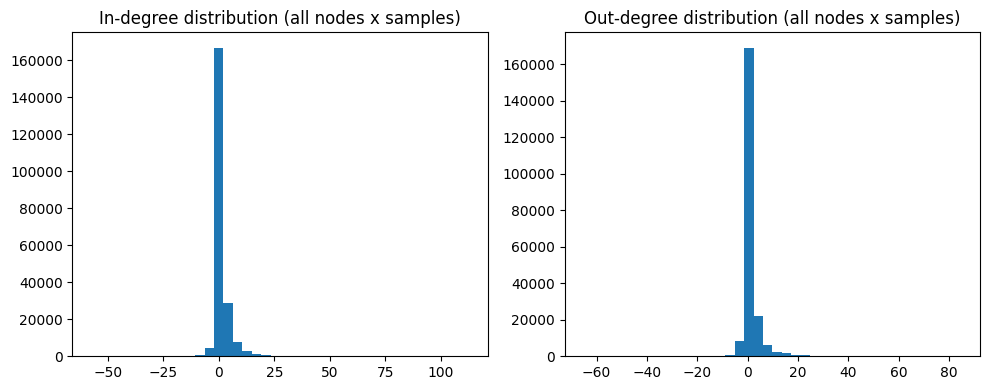

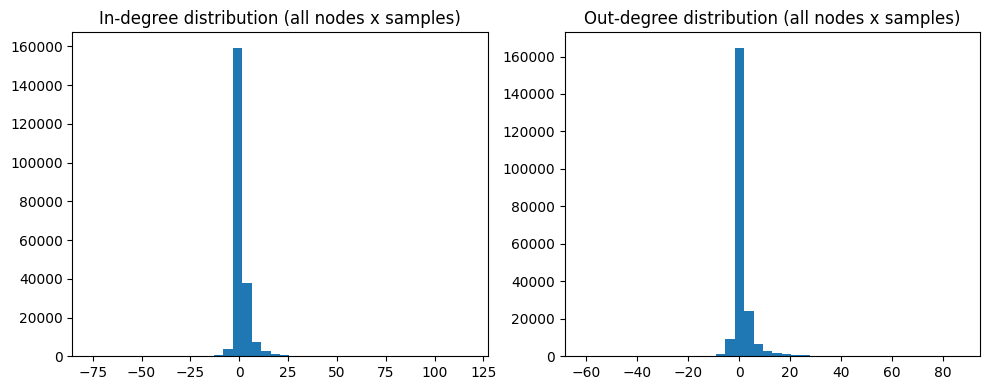

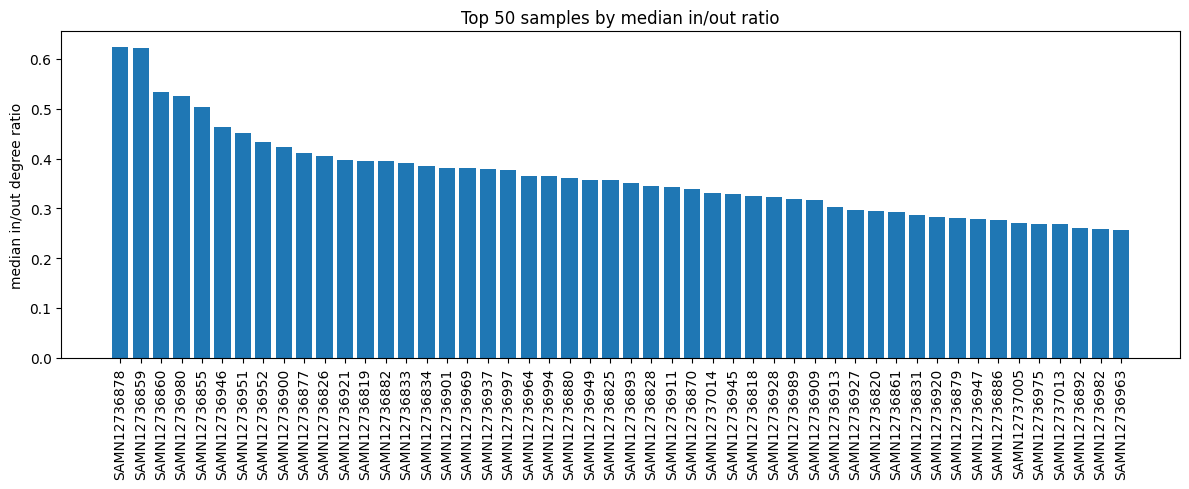

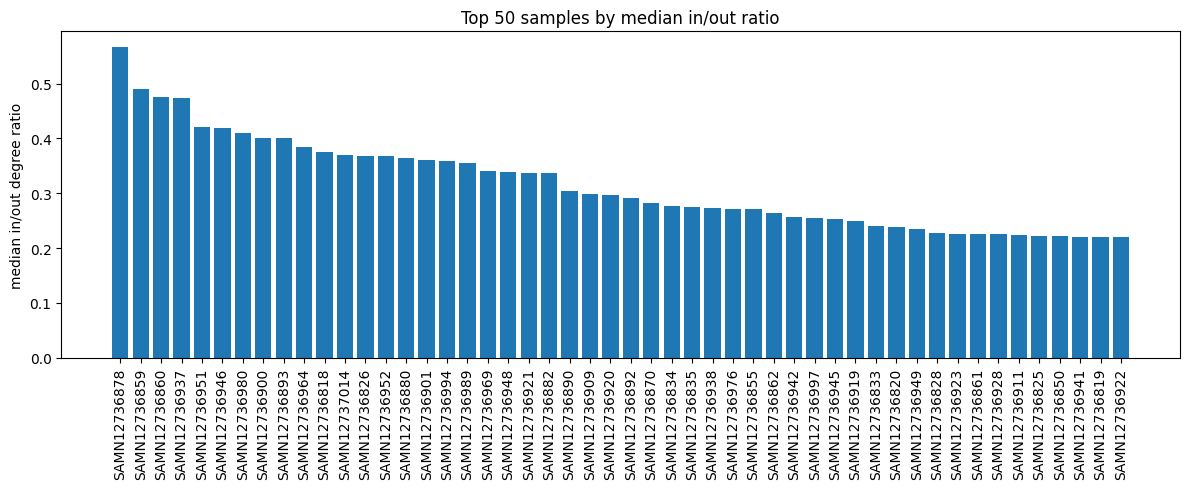

In [10]:
graphs_pearson = sample_edges_to_nx(sample_edges=sample_edges_pearson, gene_to_idx=gene_to_idx, directed=True)
graphs_spearman = sample_edges_to_nx(sample_edges=sample_edges_spearman, gene_to_idx=gene_to_idx, directed=True)

graph_df_pearson, node_df_pearson = compute_graph_and_node_stats_directed(graphs_pearson)
graph_df_spearman, node_df_spearman = compute_graph_and_node_stats_directed(graphs_spearman)

plot_in_out_degree_distributions(node_df_pearson)
plot_in_out_degree_distributions(node_df_spearman)

plot_ratio_in_out_by_sample(node_df_pearson, top_n=50)
plot_ratio_in_out_by_sample(node_df_spearman, top_n=50)